# Time series multiclass classification using LSTM for pass outcome prediction as a measure of defensive effectiveness

This notebook demonstrates how to use a recurrent neural network ([LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)) for time series forecasting with the NFL Big Data Bowl 2021 dataset to predict pass outcome for a given play. The goal is to use time series multiclass classification to learn how defensive player movement in response to offensive player movement from player tracking data can be used to predict whether a pass play will result in a **completion**, **incompletion**, **interception**, or **quarterback sack**. The classification model can then be used to predict the outcome of future plays and analyze which defensive player movements contribute to the pass outcome.

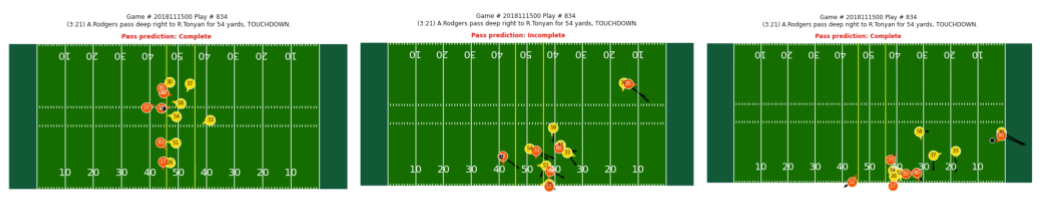

## Methodology

LSTM networks learn from a collection of input samples, where each sample is a time series, and where each step in the time series contains feature data. Therefore the shape of the input data is 3 dimensional: (&lt;number of samples&gt;, &lt;length of time series&gt;, &lt;length of features&gt;)

For this dataset, each play is an input sample, where the frames of the play are the time series, and the features are the tracking data for each player involved in the play. Each time series length and feature length must be the same for every input sample, so the time series (frames) of every play are pre-padded with zeros to match the length of the longest play in the entire dataset. Additionally, all feature sets are composed of data for the maximum possible player count at each position taken from the entire dataset. For example, if the maximum number cornerbacks seen in the entire dataset is in a single play which has 6 cornerbacks and 3 wide receivers, and the maximum number of wide receivers is seen in a separate play which has 3 cornerbacks 5 wide receivers, every feature set used for training will contain tracking data for 6 cornerbacks (CB1, CB2, ... CB6) and 5 wide receivers (WR1, WR2, .. WR5). In the cases where a play has less than the maximum possible players at each position, zero-padded data is entered for the "missing" positions. Illustration below:

```
| Samples | Time Series | Features                                        |
| ------- | ----------- | ----------------------------------------------- |
| Play 1  | Frame 1     | Player 1 data, Player 2 data, ... Player P data |
|         | Frame 2     | Player 1 data, Player 2 data, ... Player P data |
|         | ...         | ...                                             |
|         | Frame F     | Player 1 data, Player 2 data, ... Player P data |
| Play 2  | Frame 1     | Player 1 data, Player 2 data, ... Player P data |
|         | Frame 2     | Player 1 data, Player 2 data, ... Player P data |
|         | ...         | ...                                             |
|         | Frame F     | Player 1 data, Player 2 data, ... Player P data |
| ...     | ...         | ...                                             |
| Play N  | Frame 1     | Player 1 data, Player 2 data, ... Player P data |
|         | Frame 2     | Player 1 data, Player 2 data, ... Player P data |
|         | ...         | ...                                             |
|         | Frame F     | Player 1 data, Player 2 data, ... Player P data |

P = the maximum number of players possible for any play in the dataset
F = the maximum number of frames for any play in the dataset
N = the number of plays:
```

This features used for model training in this example, are each player's on-field location data, namely the **x/y position**, **speed (s)**, **acceleration (a)**, **distance traveled (dis)**, **orientation (o)**, and **direction (dir)** values for every frame of every play, as well as, each player's **height** and **weight**. This notebook outlines the process of collecting and formatting the tracking data to train an LSTM network on the supplied pass outcome classifications.

In [ ]:
# Kaggle provides 4 CPU cores, so the pandarallel module
# will use all of them for parallel processing.
!pip install pandarallel

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML, clear_output
from multiprocessing import Pool
from pandarallel import pandarallel as pl
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmnb

# Initialize pandarallel to show progress bars
pl.initialize(progress_bar=True, verbose=0)

## Reading data

Read the **players.csv**, **plays.csv**, and **weekN.csv** data files into separate data frames. Due to Kaggle memory limits, I wasn't able to train on the full dataset of all weeks.

In [ ]:
players_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2021/players.csv')
plays_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2021/plays.csv')

# Load tracking data from several weeks into a single data frame.
def processor_fn(n):
    return pd.read_csv(f'/kaggle/input/nfl-big-data-bowl-2021/week{n}.csv')

# Kaggle memory limits can only hold roughly 4-5 weeks in memory at
# a time in addition to the other data structures in this notebook.
START_WEEK = 14
END_WEEK = 17  # non-inclusive
weeks = list(range(START_WEEK, END_WEEK))
weeks_data = []
pool = Pool(processes=4)
for df in tqdmnb(pool.imap(processor_fn, iterable=weeks), total=len(weeks)):
    weeks_data.append(df)
tracking_df = pd.concat(weeks_data, ignore_index=True)

print('Dataset containing {} games and {} plays.'.format(len(tracking_df['gameId'].unique()),
                                                         len(tracking_df['playId'].unique())))

## Formatting data for training

The next several code cells format the raw input data into the shape needed for training the LSTM model. First, the x/y tracking data is normalized. The normalized x/y data is what will be used for the feature set. Next, the "position" column value for the football is given the string, "ball", so that it can be included in the feature set along with all other field positions.

In [ ]:
# Normalize the x/y coordinates according to the example here:
# https://www.kaggle.com/tombliss/tutorial#Cleaning-Data
def normalize_x(row, show_pbar=True):
    if show_pbar:
        pbar.update(1)
    if row['playDirection'] == 'left':
        return 120.0 - row['x']
    else:
        return row['x']

def normalize_y(row, show_pbar=True):
    if show_pbar:
        pbar.update(1)
    if row['playDirection'] == 'left':
        return 160/3 - row['y']
    else:
        return row['y']

# Using parallel_apply() here always seems to get stuck for some reason that I haven't
# figured out yet. The normal apply() function seems to succeed more consistently.
pbar = tqdm(range(len(tracking_df)*2))
tracking_df['x_norm'] = tracking_df[['x', 'playDirection']].apply(normalize_x, axis=1)
tracking_df['y_norm'] = tracking_df[['y', 'playDirection']].apply(normalize_y, axis=1)
del pbar
# The 'position' column value for the football is always set to NaN so this
# will change the value to 'ball' so that it is included in the feature data.
tracking_df.loc[tracking_df['displayName'] == 'Football', ['position']] = 'ball'
tracking_df[tracking_df['displayName'] == 'Football'].head().style.apply(lambda c: ['background-color:yellow' for _ in c], subset=['position'])


This cell creates a data frame of every game/play combination. This will be used to separate each play into its own time series.

In [ ]:
# Get all game/play combinations
gp_df = tracking_df[['gameId', 'playId']].drop_duplicates()
gp_df.reset_index(drop=True, inplace=True)
gp_df.head()

In [ ]:
# Collect a record of the number of players in each position in every play.
# This will be used later to determine the maxiumum possible number of players
# for each position, which in turn determines how many features are needed
# to be collected (or zero-padded) at every position.
def get_position_counts(row):
    expr = (tracking_df['gameId'] == row['gameId']) & (tracking_df['playId'] == row['playId'])
    df = tracking_df.loc[expr]
    # The number of positions involved in the play should be the same for every frame
    # in the play, so only count the number of positions in the first frame.
    vc = df.loc[df['frameId'] == 1, 'position'].value_counts()
    return pd.DataFrame(np.array([vc.values]), columns=vc.keys())

pos_counts = gp_df.parallel_apply(get_position_counts, axis=1)
pos_counts_max = pd.concat([df for df in pos_counts]).max().astype(int)
del pos_counts  # Mark temp object for deletion to free memory
pos_counts_max.head()

In [ ]:
# These are the column names to use as feature data.
feature_cols = ['x_norm', 'y_norm', 's', 'a', 'dis', 'o', 'dir']
# Extra tracking data columns needed for formatting features.
tracking_cols = ['position', 'frameId']
# Player columns for looking up player data
player_cols = ['height', 'weight']
# These are the play outcomes to use to limit data used for a play sequence.
play_outcomes = ['pass_outcome_caught', 'pass_outcome_incomplete', 'pass_outcome_interception',
                 'pass_outcome_touchdown', 'qb_sack', 'qb_strip_sack', 'touchdown']

def get_play_indicies(play_df):
    # Only gather data between the ball snap and pass outcome
    start_idx = play_df['event'].eq('ball_snap').idxmax()
    end_idx = play_df['event'].isin(play_outcomes).idxmax()
    # idxmax() gets the index of the first occurance, so subtract one
    # from the index to keep the time series samples the same length
    end_idx = end_idx - 1 if end_idx else len(play_df)
    return start_idx, end_idx

def trim_plays(row):
    expr = (tracking_df['gameId'] == row['gameId']) & (tracking_df['playId'] == row['playId'])
    df = tracking_df.loc[expr]
    start, end = get_play_indicies(df)
    return df.loc[start:end]

# Trim each play so that it starts at the "ball snap" event, and ends at
# a "pass outcome" event, to reduce the amount of data processed and because
# the data before and after these events is unlikely to give any better predictions.
trimmed_plays = gp_df.parallel_apply(trim_plays, axis=1)
# Create a new data frame with just the data from the feature
# colunms needed plus a few other categorical columns.
play_data_df = pd.concat([df[feature_cols + tracking_cols + ['nflId', 'gameId', 'playId']]
                          for df in trimmed_plays])
del trimmed_plays
play_data_df.head()


In [ ]:
# Get the pass result for every game/play combination.
def get_pass_results(row):
    return plays_df.loc[(plays_df['gameId'] == row['gameId']) &
                        (plays_df['playId'] == row['playId']),
                        'passResult'].values[0]

feature_label_df = gp_df.copy()
feature_label_df['labels'] = gp_df.parallel_apply(get_pass_results, axis=1)
feature_label_df.head()

The following function does most of the work to collect the features for every frame of every play. As such, it also takes the longest time to run. It is designed to be used with the `apply()` method of a data frame, which passes in each row that contains a `gameId` and `playId` to process. Play data is pulled from the supplied `play_data_source_df` data frame which contains the tracking data. Tracking data from each position in the play is collected and concatinated into a single 1-dimentional array. For all other positions not present in the current play, zero-padded data is added. The position data is collected in sorted order, so that the order of each position is the same in the feature data. Additionally, the height and weight for each player involved in the play is also collected and added to the feature set for additional training information. For 4-5 weeks worth of tracking data, this function can take roughly 1-2 hours to run.

In [ ]:
# Use a sorted list of position ids so that the feature
# data for each sample is always in the same order.
all_positions = sorted(pos_counts_max.keys())

def format_features(row, show_pbar=True, play_data_source_df=None):
    if play_data_source_df is None:
        assert 'The play data source data frame is required!'
    if show_pbar:
        # Clear output so it doesn't scroll forever.
        # This does cause some anoying flickering however :(
        clear_output()
        # There are 4 CPUs so updating the progress bar by 4
        # gets us kind-of close to a real progress bar.
        pbar.update(4)
    expr = (play_data_source_df['gameId'] == row['gameId']) & (play_data_source_df['playId'] == row['playId'])
    # Get all data for the current game/play combination
    play_df = play_data_source_df.loc[expr]
    frames = sorted(play_df['frameId'].unique())
    frame_data = []
    # Iterate through every frame in the play
    for fid in frames:
        features = np.array([])
        # Iterate through every possible position even if a
        # particular position is not included in this play.
        for pos in all_positions:
            # Get the values for the specific feature columns for the current position
            # at the current frame. The return values of `pos_data` is either an ndarray
            # of length zero, or an ndarray with a length equal to the number of occurances
            # the current position appears in the current play.
            pos_data = play_df.loc[(play_df['frameId'] == fid) &
                                   (play_df['position'] == pos),
                                   feature_cols].values
            # Get the NFL IDs for the player(s) at each position in order to look up their player data.
            nflIds = play_df.loc[(play_df['frameId'] == fid) &
                                 (play_df['position'] == pos),
                                 ['nflId']].values
            # Include player data in the feature set.
            player_hw = []
            if len(nflIds):
                cols = players_df.loc[players_df['nflId'].isin(np.hstack(nflIds)), player_cols]
                try:
                    # Convert values from string to float32.
                    player_hw = cols.values.astype('float32')
                except ValueError:
                    # Some values in the "height" column are formatted like "6-2",
                    # which causes the ValueError exception, so manually parse as float.
                    ht_wt = np.array([])
                    for t in cols.itertuples():
                        if '-' in t.height:
                            ft_in = t.height.split('-')
                            h = float(ft_in[0])*12 + float(ft_in[1])
                        else:
                            h = float(t.height)
                        w = float(t.weight)
                        ht_wt = np.append(ht_wt, [h, w])
                    player_hw = ht_wt.reshape(cols.shape)
            # If no NFL IDs or player data are returned, set the player data to zero.
            if not len(player_hw):
                player_hw = np.zeros((pos_data.shape[0], len(player_cols)))
            # Initialize with an array the same shape as the array
            # will be appended so that there is not a shape mismatch.
            pos_player_data = np.array([np.zeros(len(feature_cols) + len(player_cols))])
            for i, pd in enumerate(pos_data):
                if i < len(player_hw):
                    pos_player_data = np.append(pos_player_data,
                                                np.array([np.hstack((pd, player_hw[i]))]),
                                                axis=0)
                else:
                    pos_player_data = np.append(pos_player_data,
                                                np.array([np.hstack((pd, np.zeros(2)))]),
                                                axis=0)
            # Remove the initial row of zeros used to initialize the array.
            pos_player_data = pos_player_data[1:]
            # Replace any NaN values will 0.0. Having NaN values in the dataset
            # will cause the training loss to fail in the LSTM model.
            np.nan_to_num(pos_player_data, copy=False)
            diff = pos_counts_max[pos] - len(pos_player_data)
            if diff > 0:
                # If the number of occurances of the current position in this play is less
                # than the maximum possible occurances of this position across all plays, 
                # then pad the array with zeros so that every position has the same number
                # of occurances in the data input into the model.
                padding_data = [[0.0] * (len(feature_cols) + len(player_cols))] * diff
                pos_player_data = np.append(pos_player_data, padding_data, axis=0)
            features = np.hstack((features, np.hstack(pos_player_data)))
        frame_data.append(features)
    return np.array(frame_data)

In [ ]:
# Having the progress bar enabled causes parallel processing to fail with
# the error "OverflowError: int too big to convert" for some reason.
# Turning off the progress bar makes it run successfully:
# https://github.com/nalepae/pandarallel/issues/63
pl.initialize(progress_bar=False, verbose=0)
# Use a make-shift, manually-updated progress bar as a replacement.
pbar = tqdm(range(len(gp_df)))
show_pbar_arg = True
feature_label_df['features'] = gp_df.parallel_apply(format_features, axis=1, args=[show_pbar_arg, play_data_df])
del pbar
feature_label_df.head()

In [ ]:
# Remove empty rows.
print('Total before removing empty rows:', len(feature_label_df))
feature_label_df = feature_label_df.loc[feature_label_df['features'].str.len() > 0]
print('Total after removing empty rows:', len(feature_label_df))

In [ ]:
# Input shape dimensions for the LSTM model.
# timeseries_dim is the length of the longest play in the dataset.
timeseries_dim = feature_label_df['features'].apply(lambda x: x.shape[0]).max()
# feature_dim is the length of the number of total postions times number of feature columns.
feature_dim = pos_counts_max.sum() * (len(feature_cols) + len(player_cols))
input_shape = (timeseries_dim, feature_dim)
print('Input shape:', input_shape)


In [ ]:
def equalize_timeseries(timeseries):
    diff = timeseries_dim - len(timeseries)
    if diff > 0:
        pad = [np.zeros(feature_dim)] * diff
        # Pre-pad the zero data
        return np.vstack((np.array(pad), timeseries))
    else:
        return timeseries

# Turn the pandarallel progress bar back on after it was turned off in the previous cell.
pl.initialize(progress_bar=True, verbose=0)
feature_label_df['features'] = feature_label_df['features'].parallel_apply(equalize_timeseries)

# Verify the shape of every time series
bad_idx = []
for i, s in feature_label_df['features'].items():
    if s.shape != input_shape:
        bad_idx.append(i)
if len(bad_idx):
    print('Shape mismatches found:', bad_idx)
else:
    print('No shape mismatches found!')

## Train/validation/test splits

The collected data is split into 70% training, 20% validation, and 10% testing. Each of the 4 labels (`C`, `I`, `S`, `IN`) are one-hot encoded. The order of the one-hot encoding is taken from the distribution of labels in the entire dataset.

In [ ]:
# Split the input data into train, validate, test sets.
from tabulate import tabulate
from sklearn.model_selection import train_test_split

features_input = np.stack(feature_label_df['features'])

# Since there are only 4 categories it is easy to hand-code the one-hot encoding.
# Order is based on number of occurnaces of each play result type, which can be seen by running:
# feature_label_df['labels'].value_counts()
category_lookup = {'C': [1.0, 0.0, 0.0, 0.0],
                   'I': [0.0, 1.0, 0.0, 0.0],
                   'S': [0.0, 0.0, 1.0, 0.0],
                   'IN': [0.0, 0.0, 0.0, 1.0]}

categories = feature_label_df['labels'].apply(lambda lbl: category_lookup[lbl])
labels_input = np.stack(categories)

train_x, test_x, train_y, test_y = train_test_split(features_input, labels_input, test_size=0.1)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.23)

print(tabulate(
    [['Train X:', len(train_x), train_x.shape],
     ['Val X:', len(val_x), val_x.shape],
     ['Test X:', len(test_x), test_x.shape],
     ['Train Y:', len(train_y), train_y.shape],
     ['Val Y:', len(val_y), val_y.shape],
     ['Test Y:', len(test_y), test_y.shape]],
    headers=['', 'Length', 'Shape']
))

## The Model

The model used here is a straight-forward LSTM neural network, implemented in Keras, backed by Tensorflow. A dropout layer is added after the LSTM layer to reduce overfitting. The dense layer reduces the network data to our 4 label categories. An L2 regularizer is included in this layer to include an additional measure against overfitting. The final softmax layer provides probabilities for the 4 classes in this multiclass problem. The model is compiled with a `CategoricalCrossentropy` loss function and `adam` optimizer.

The loss function also uses label smoothing to account for the imbalance in the label distribution. The pass outcome for the full dataset is overwhelmingly skewed towards `Completion` and there is a very small number of `Incomplete`. Without label smoothing, model predictions for `Sack` and `Interception` tend to fall to zero, and all predictions end up being `Completion`. I tried several label smoothing techniques, and adding a level smoothing parameter to the loss function seemed to work the best. Other techniques tried included [`sklearn.utils.class_weight.compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) ([example](https://gist.github.com/MattLowrieDS/f977588f8ef54c903711836918145914)), [smoothen weights technique](https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310) ([example](https://gist.github.com/MattLowrieDS/421498d8b93d677fc93c97c09366e07c)), and label smoothing by factoring the label set with itself ([method #1 documented here](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/)) ([example](https://gist.github.com/MattLowrieDS/f6eabe67b8e6f2abae221774833c12ce)).

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.metrics import AUC
from keras.losses import CategoricalCrossentropy

model = Sequential()
model.add(LSTM(100, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(4, kernel_regularizer='l2'))
model.add(Activation('softmax'))
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.993),
              optimizer='adam', metrics=[AUC()])
model.summary()

In [ ]:
# Run training and plot the results.
EPOCHS = 10
BATCH_SIZE = 96
history = model.fit(train_x, train_y,
                    validation_data=(val_x, val_y),
                    epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot the loss and accuracy
fig = plt.figure(figsize=(12, 4))

loss_plot = fig.add_subplot(121)
loss_plot.plot(history.history['loss'], color='blue', label='Train')
loss_plot.plot(history.history['val_loss'], color='darkorange', linestyle='dashed', label='Val')
loss_plot.title.set_text('Loss')
loss_plot.legend()

auc_plot = fig.add_subplot(1, 2, 2)
# The metrics key appends a numbered suffix every time the model is recompiled
# (e.g., "auc_1"), so find history for the key that starts with the "acc" prefix.
auc_hist = next(v for k, v in history.history.items() if k.startswith('auc'))
auc_plot.plot(auc_hist, color='blue', label='Train')
val_auc_hist = next(v for k, v in history.history.items() if k.startswith('val_auc'))
auc_plot.plot(val_auc_hist, color='darkorange', linestyle='dashed', label='Val')
auc_plot.title.set_text('AUC')
auc_plot.legend()
plt.show()

In [ ]:
# Evaluate with the test set.
score = model.evaluate(test_x, test_y, verbose=2)
print('Loss:', score[0])
print('AUC:', score[1])

## Training metrics

As seen from the confusion matrix, the training results skew heavily towards predicting passes as `Completion`, which is the dominant outcome classification in the dataset. It will take some more work to get the best balance of precision and recall across the 4 classes.

In [ ]:
# Display the confusion matrix
import seaborn as sbn
from sklearn.metrics import confusion_matrix

pred_y = model.predict(test_x)
predictions = pred_y.argmax(axis=1)
actual = test_y.argmax(axis=1)
cm = confusion_matrix(actual, predictions)
print(cm)
plt.figure(figsize=(8, 6))
ax = plt.subplot()
sbn.heatmap(cm, annot=True, fmt='d', ax=ax,
            xticklabels=category_lookup.keys(),
            yticklabels=category_lookup.keys(),
            cmap='Blues')
ax.set_xlabel('Predictions')
ax.set_ylabel('Actual')

In [ ]:
# View the classification report.
from sklearn.metrics import classification_report

print(classification_report(actual, predictions, target_names=category_lookup.keys()))

## Application

With the trained model, the similar tracking data for future plays, and even sub-series of plays, can be used to predict the pass outcome, potentially in real time. For example, as a play progresses, a prediction can be made for each moment of the play using the tracking data up to the current moment. Based on the prediction results, analysis of the defensive coverage (either visually or programmatically) can be made to see where changes in any defensive player's position and orientation could alter the prediction outcome, for example from `Complete` to `Interception`.

As an example, below is the function used to format in-play data for making predictions with the trained model. While processing each frame of a play for animation (hidden in the cell below), all of the tracking data for the play up to the point of the current frame can be passed to the `get_prediction()` function. This function will format the data using the same formatting functions used for the training data. It then passes the formatted time series to the model and de-classifies the prediction into a pass outcome. This prediction is then rendered into each frame of the output animation.

In [ ]:
# Mapping of prediction index to human-readable name to display in the output rendering.
prediction_lookup = {0: 'Complete', 1: 'Incomplete', 2: 'Sack', 3: 'Interception'}

# Creates a prediction for the given sub-section of a play.
# Input data frame has unprocessed tracking data.
def get_prediction(df):
    # Normalize the given data.
    show_progress_bar_arg = False
    df['x_norm'] = df[['x', 'playDirection']].apply(normalize_x, axis=1, args=[show_progress_bar_arg])
    df['y_norm'] = df[['y', 'playDirection']].apply(normalize_y, axis=1, args=[show_progress_bar_arg])
    # The supplied data frame (df) will only have one game id and
    # one play id as the game/play combination chosen to animate.
    gp_df = pd.DataFrame({'gameId': df['gameId'].unique(), 'playId': df['playId'].unique()})
    pred_features = gp_df.apply(format_features, axis=1, args=[show_progress_bar_arg, df])
    pred_input = pred_features.apply(equalize_timeseries)
    pred_input = np.stack(pred_input)
    pred = model.predict(pred_input)
    return prediction_lookup[pred.argmax()]

Animation code cell is lengthy so it is hidden below. It is reused from [ar2017](https://www.kaggle.com/ar2017)'s notebook here: https://www.kaggle.com/ar2017/nfl-big-data-bowl-2021-animating-players-movement

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter

from datetime import datetime
import dateutil
from math import radians
from IPython.display import Video
import warnings
warnings.filterwarnings('ignore')

def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
    return fig, ax

def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
        
def animate_player_movement(weekNumber, playId, gameId):
    weekData = pd.read_csv('../input/nfl-big-data-bowl-2021/week' + str(weekNumber) + '.csv')
    playData = pd.read_csv('../input/nfl-big-data-bowl-2021/plays.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    # Need to replace NaN in the 'position' column with 'ball' to match the training data.
    playFootball['position'].fillna('ball', inplace=True)

    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white'))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white'))
        
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
        
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['team']))
        
        # Display the pass outcome prediction in the title area
        features_df = pd.concat([playHome.loc[playHome['time'] <= time],
                                 playAway.loc[playAway['time'] <= time],
                                 playFootball.loc[playFootball['time'] <= time]])
        prediction = get_prediction(features_df)
        patch.append(plt.text(40, 55, f'Pass prediction: {prediction}', ha='left', color='red', size='x-large', weight='bold'))
        
        return patch
    
    ims = [[]]
    for time in tqdmnb(np.arange(minTime, maxTime+1)):
#    for time in [minTime, minTime+1, minTime+2]:
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

## Results

Create an animation of a random play to show an example of prediction results. Here is an example video that shows the goal for prediction output: https://youtu.be/dl-GfrbLumg

In [ ]:
GAME = 2018111500
PLAY = 834
WEEK = 11
movie = animate_player_movement(WEEK, PLAY, GAME)
file_name = f'{GAME}-{PLAY}.mp4'
movie.save(file_name)
Video(file_name)

## Future Work

Although the results here are encouraging, there are a few areas which can be addressed to improve prediction accuracy.

### Feature engineering

The example here simply uses raw tracking and player data for training the model. And as seen in the results, it is hard to differentiate between a successful completion and an incomplete pass based only on position data. Some additional features that could be added, which might improve prediction accuracy, include:
* The distance of the defenders from the target receiver
* A "stamina" value for each defensive player, calculated from number of plays each defender was involved in up to the current play, and what distance they've covered already in the game. For example, if a defender has been involved in several plays in a row.
* The "motivation" of the defensive team collectively, factored by the down of the current play, the current score of the game (is the defensive team ahead/behind by one score), and game quarter (i.e., does the defense need to make a stop to win the game?)

Additionally, since the difference between a successful catch and an incompletion when there is close defensive coverage can sometimes come down to arm strength, another interesting signal would be to add the each player's arm position in 3D space, as determined by [pose detection](https://developers.google.com/ml-kit/vision/pose-detection).

### Improved model

My experiments with label smoothing only increased accuracy by a small amount. There is another technique of using [ensemble adaptive weighting](https://www.hindawi.com/journals/mpe/2018/2470171/) which could improve accuracy.

Newer time series classification models other than LSTM could be used here as well, including [LSTM Autoencoders](https://machinelearningmastery.com/lstm-autoencoders/) or [InceptionTime](https://arxiv.org/abs/1909.04939).